In [1]:
from numqt import *

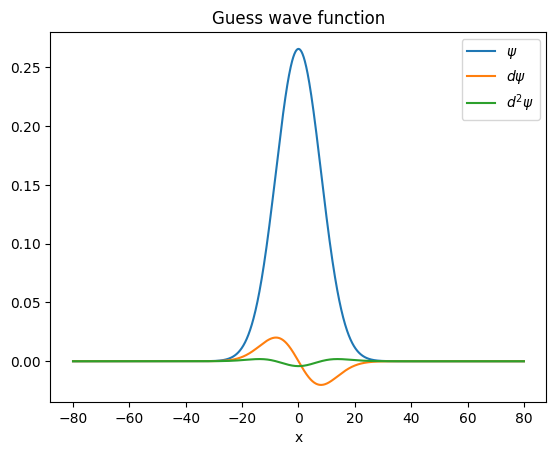

In [2]:
#-----------------------------------------------------------
# Characteristic lengths of the problem
#-----------------------------------------------------------
Lx = 8 # Characteristic length along x
Ly = 6 # Characteristic length along y
LB = 5 # Magnetic length

#-----------------------------------------------------------
# Problem's parameters
#-----------------------------------------------------------
hbar = 1
m = 0.055 # e-mass
e = 1 # e-charge
mu_b = e * hbar / (2 * m) # Bohr magneton

wx = hbar / (m * Lx**2) # x confinement frequency
wy = hbar / (m * Ly**2) # y confinement frequency

Bz = hbar / (e * LB**2) # magnetic field
g = 0 # g-factor
Delta = g * Bz * hbar * mu_b

#-----------------------------------------------------------
# Simulation parameters
#-----------------------------------------------------------
xbounds = (-10*Lx, 10*Lx) #(THIS PARAMETER IS HIGHLY IMPORTANT AND MUST BE CHOSEN CAREFULLY WHEN VARYING N_states: TOO SMALL AND THE WAVEFUNCTION HAS NO TIME TO DECAY, TOO LARGE AND INTEGRATION ACCUMULATES ERROR FROM INTEGRATING REGIONS OF |WAVEFUNCTION| < floating poin precision)
ybounds = (-10*Ly, 10*Ly) #(THIS PARAMETER IS HIGHLY IMPORTANT AND MUST BE CHOSEN CAREFULLY WHEN VARYING N_states: TOO SMALL AND THE WAVEFUNCTION HAS NO TIME TO DECAY, TOO LARGE AND INTEGRATION ACCUMULATES ERROR FROM INTEGRATING REGIONS OF |WAVEFUNCTION| < floating poin precision)

dx = 0.1 # spacing
dy = 0.1 # spacing

nx = int(np.abs(xbounds[1] - xbounds[0]) / dx)
ny = int(np.abs(ybounds[1] - ybounds[0]) / dy)

#-----------------------------------------------------------
# Creating grid
#-----------------------------------------------------------
mesh_obj = Mesh(dims=2,
                 xbounds=xbounds,
                 ybounds=ybounds,
                 nx=nx,
                 ny=ny,
               )

dimx = mesh_obj.Nx
dimy = mesh_obj.Ny
#-----------------------------------------------------------
# Guess basis
#-----------------------------------------------------------
N_states = 25
psix_fn = lambda n, mesh: ho_state(n, mesh, omega = wx, mass = m, hbar = hbar)
psiy_fn = lambda n, mesh: ho_state(n, mesh, omega = wy, mass = m, hbar = hbar)

basis = {"x" : (psix_fn, N_states),
         "y" : (psiy_fn, N_states)}

for i in range(3):
    plt.plot(mesh_obj.mesh_x, psix_fn(0, mesh_obj.mesh_x)[i], label = [r"$\psi$", r"$d\psi$", r"$d^2\psi$"][i])
plt.xlabel("x")
plt.title("Guess wave function")
plt.legend()

In [5]:
#-----------------------------------------------------------
# Obtaining canonical operators
#-----------------------------------------------------------
operators = canonic_ops(mesh_obj, basis = basis, ops_to_compute = ["p2", "x2"], additional_subspaces = [np.eye(2)], hbar=1, limit_divisions=max(nx,ny))
px2, py2 = operators.get_ops()["p2"]
x2, y2 = operators.get_ops()["x2"]

#-----------------------------------------------------------
# Obtaining spin operators
#-----------------------------------------------------------
s0, sx, sy, sz, sx2, sy2, sz2 = spin12(dimx = N_states, dimy = N_states, dimz = None, hbar = 2) # hbar = 2 ensures no rescaling of spin12 operators

#-----------------------------------------------------------
# Constructing the Hamiltonian
#-----------------------------------------------------------
H = 0.5 * Delta * sz + (px2 + py2) / (2*m) + 0.5 * m * (x2 * wx**2 + y2 * wy**2)
H = Hamiltonian(H, mesh_obj, basis = basis, other_subspaces_dims=[2])

In [6]:
k = N_states**2 - 2
energies, wavefunctions = H.solve(k)

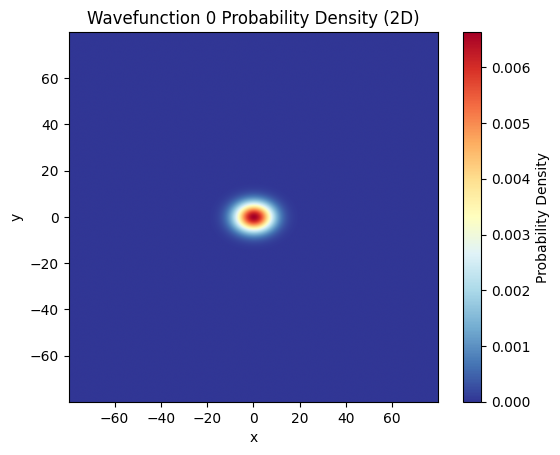

In [7]:
H.plot(0)

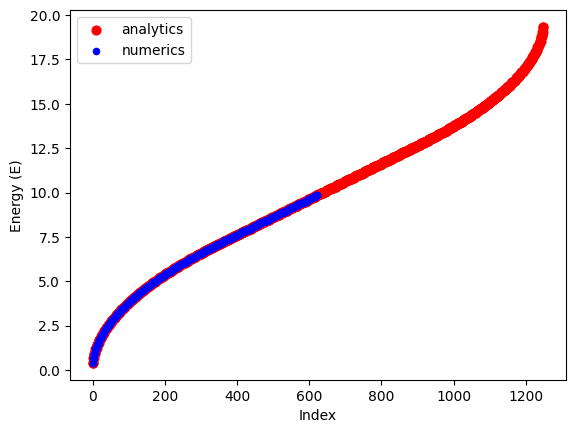

In [8]:
# Calculate analytic values
analytic_energies = sorted([hbar * wx * (nx + 0.5) + hbar * wy * (ny + 0.5) + (-1)**s * Delta * 0.5 
                           for nx in range(N_states)
                           for ny in range(N_states)
                           for s in (0,1)])

# Create proper x indices for both datasets
x_analytic = list(range(len(analytic_energies)))
x_numeric = list(range(len(energies)))
y_numeric = sorted(energies)  # Define y_numeric as the sorted energies

# Plot with correct indices
plt.scatter(x_analytic, analytic_energies, c="r", s=40, label="analytics")
plt.scatter(x_numeric, y_numeric, c="b", s=20, label="numerics")
plt.legend()
plt.xlabel("Index")
plt.ylabel("Energy (E)")
plt.show()